In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# LOAD DATA

In [4]:

print("\n📂 Loading datasets...")

try:
    # Load Fear & Greed Index
    fear_greed = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ds_MohamadSakir/needed/csv_files/fear_greed_index.csv')
    print(f"✓ Fear & Greed Index loaded: {len(fear_greed):,} records")

    # Load Trader Data
    trader_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ds_MohamadSakir/needed/csv_files/historical_data.csv')
    print(f"✓ Historical Trader Data loaded: {len(trader_data):,} records")

except FileNotFoundError as e:
    print(f"\n❌ ERROR: {e}")
    print("\nPlease ensure the following files are in the same directory:")
    print("  1. fear_greed_index.csv")
    print("  2. historical_data.csv")
    exit(1)


📂 Loading datasets...
✓ Fear & Greed Index loaded: 2,644 records
✓ Historical Trader Data loaded: 211,224 records


# DATA PREPROCESSING

In [5]:
print("\n" + "=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

# Convert date columns
fear_greed['date'] = pd.to_datetime(fear_greed['date'])
trader_data['datetime'] = pd.to_datetime(trader_data['Timestamp'], unit='ms')
trader_data['date'] = trader_data['datetime'].dt.date
trader_data['date'] = pd.to_datetime(trader_data['date'])

print(f"\n📅 Date Ranges:")
print(f"  Fear & Greed: {fear_greed['date'].min()} to {fear_greed['date'].max()}")
print(f"  Trader Data: {trader_data['date'].min()} to {trader_data['date'].max()}")

print(f"\n📊 Fear & Greed Index Distribution:")
sentiment_dist = fear_greed['classification'].value_counts()
for sentiment, count in sentiment_dist.items():
    print(f"  {sentiment:15s}: {count:5d} days ({count/len(fear_greed)*100:5.1f}%)")

print(f"\n📊 Trader Data Overview:")
print(f"  Unique Accounts: {trader_data['Account'].nunique():,}")
print(f"  Unique Coins: {trader_data['Coin'].nunique()}")
print(f"  Total Volume (USD): ${trader_data['Size USD'].sum():,.2f}")
print(f"  Total Trades: {len(trader_data):,}")


DATA PREPROCESSING

📅 Date Ranges:
  Fear & Greed: 2018-02-01 00:00:00 to 2025-05-02 00:00:00
  Trader Data: 2023-03-28 00:00:00 to 2025-06-15 00:00:00

📊 Fear & Greed Index Distribution:
  Fear           :   781 days ( 29.5%)
  Greed          :   633 days ( 23.9%)
  Extreme Fear   :   508 days ( 19.2%)
  Neutral        :   396 days ( 15.0%)
  Extreme Greed  :   326 days ( 12.3%)

📊 Trader Data Overview:
  Unique Accounts: 32
  Unique Coins: 246
  Total Volume (USD): $1,191,187,442.46
  Total Trades: 211,224


# FEATURE ENGINEERING

In [6]:
print("\n" + "=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Aggregate trader metrics by date
print("\n⚙️  Aggregating daily metrics...")
daily_metrics = trader_data.groupby('date').agg({
    'Size USD': ['sum', 'mean', 'count'],
    'Closed PnL': ['sum', 'mean'],
    'Fee': 'sum',
    'Account': 'nunique',
    'Coin': 'nunique'
}).reset_index()

daily_metrics.columns = ['date', 'total_volume', 'avg_trade_size', 'num_trades',
                         'total_pnl', 'avg_pnl', 'total_fees', 'unique_traders', 'unique_coins']

# Calculate additional metrics
daily_metrics['profitable_ratio'] = daily_metrics['total_pnl'] / daily_metrics['total_volume']
daily_metrics['net_profit'] = daily_metrics['total_pnl'] - daily_metrics['total_fees']
daily_metrics['roi'] = (daily_metrics['net_profit'] / daily_metrics['total_volume'] * 100)
daily_metrics['avg_fee_per_trade'] = daily_metrics['total_fees'] / daily_metrics['num_trades']

# Merge with sentiment data
merged_data = pd.merge(daily_metrics, fear_greed[['date', 'value', 'classification']],
                       on='date', how='inner')

print(f"✓ Merged dataset: {len(merged_data):,} days of overlapping data")
print(f"✓ Date range: {merged_data['date'].min()} to {merged_data['date'].max()}")


FEATURE ENGINEERING

⚙️  Aggregating daily metrics...
✓ Merged dataset: 6 days of overlapping data
✓ Date range: 2023-03-28 00:00:00 to 2025-02-19 00:00:00


# STATISTICAL ANALYSIS

In [7]:

print("\n" + "=" * 80)
print("STATISTICAL ANALYSIS BY SENTIMENT")
print("=" * 80)

# Group by sentiment classification
sentiment_stats = merged_data.groupby('classification').agg({
    'total_volume': ['mean', 'std', 'sum', 'count'],
    'num_trades': ['mean', 'std', 'sum'],
    'total_pnl': ['mean', 'std', 'sum'],
    'avg_pnl': ['mean', 'std'],
    'unique_traders': ['mean', 'std'],
    'profitable_ratio': ['mean', 'std'],
    'roi': ['mean', 'std'],
    'total_fees': ['sum']
}).round(2)

print("\n📈 Comprehensive Metrics by Market Sentiment:")
print(sentiment_stats.to_string())


STATISTICAL ANALYSIS BY SENTIMENT

📈 Comprehensive Metrics by Market Sentiment:
                total_volume                                 num_trades                     total_pnl                        avg_pnl        unique_traders        profitable_ratio         roi       total_fees
                        mean         std           sum count       mean       std     sum        mean        std         sum    mean    std           mean    std             mean   std  mean   std        sum
classification                                                                                                                                                                                                 
Extreme Greed   3.940677e+07         NaN  3.940677e+07     1    6962.00       NaN    6962   176965.49        NaN   176965.49   25.42    NaN           5.00    NaN             0.00   NaN  0.43   NaN    6812.78
Fear            7.041585e+08         NaN  7.041585e+08     1  133871.00       NaN  1338

In [8]:
# Calculate win rates
print("\n⚙️  Calculating win rates...")
trader_data['is_profitable'] = trader_data['Closed PnL'] > 0
trader_with_sentiment = trader_data.merge(
    fear_greed[['date', 'classification']], on='date', how='inner'
)

win_rates = trader_with_sentiment.groupby('classification').agg({
    'is_profitable': ['mean', 'sum', 'count']
})
win_rates.columns = ['win_rate', 'winning_trades', 'total_trades']
win_rates['win_rate_pct'] = (win_rates['win_rate'] * 100).round(2)
win_rates['losing_trades'] = win_rates['total_trades'] - win_rates['winning_trades']

print("\n🎯 Win Rate Analysis by Sentiment:")
print(win_rates[['win_rate_pct', 'winning_trades', 'losing_trades', 'total_trades']].to_string())


⚙️  Calculating win rates...

🎯 Win Rate Analysis by Sentiment:
                win_rate_pct  winning_trades  losing_trades  total_trades
classification                                                           
Extreme Greed          49.01            3412           3550          6962
Fear                   41.51           55576          78295        133871
Greed                  44.65           16202          20087         36289
Neutral                31.72            2265           4876          7141


# VISUALIZATIONS

In [47]:
# Define color scheme
colors = {
    'Extreme Fear': '#d62728',
    'Fear': '#ff7f0e',
    'Neutral': '#bcbd22',
    'Greed': '#2ca02c',
    'Extreme Greed': '#17becf'
}

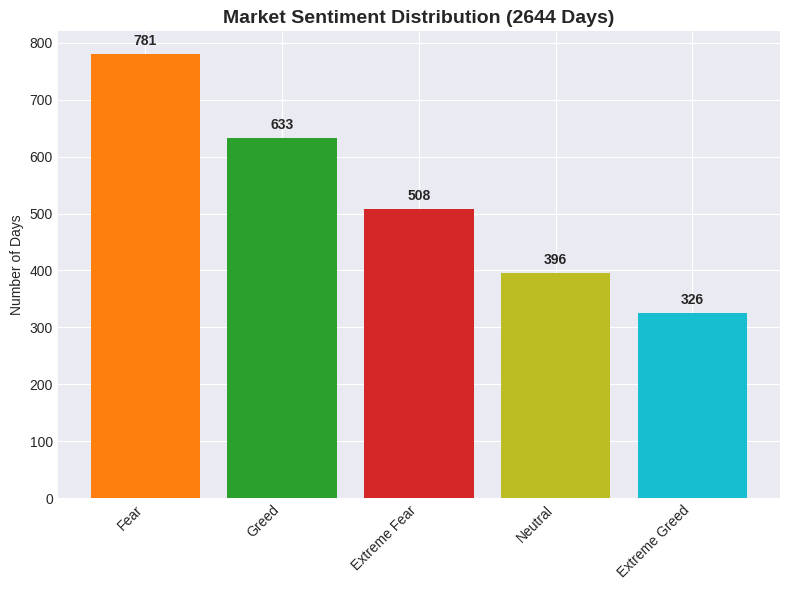

In [48]:
# 1. Sentiment Distribution
plt.figure(figsize=(8, 6))

sentiment_counts = fear_greed['classification'].value_counts()

bars = plt.bar(
    range(len(sentiment_counts)),
    sentiment_counts.values,
    color=[colors.get(x, '#888888') for x in sentiment_counts.index]
)

plt.xticks(
    range(len(sentiment_counts)),
    sentiment_counts.index,
    rotation=45,
    ha='right'
)

plt.title(
    f'Market Sentiment Distribution ({len(fear_greed)} Days)',
    fontsize=14,
    fontweight='bold'
)

plt.ylabel('Number of Days')

for i, (idx, v) in enumerate(sentiment_counts.items()):
    plt.text(
        i,
        v + max(sentiment_counts.values) * 0.02,
        str(v),
        ha='center',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


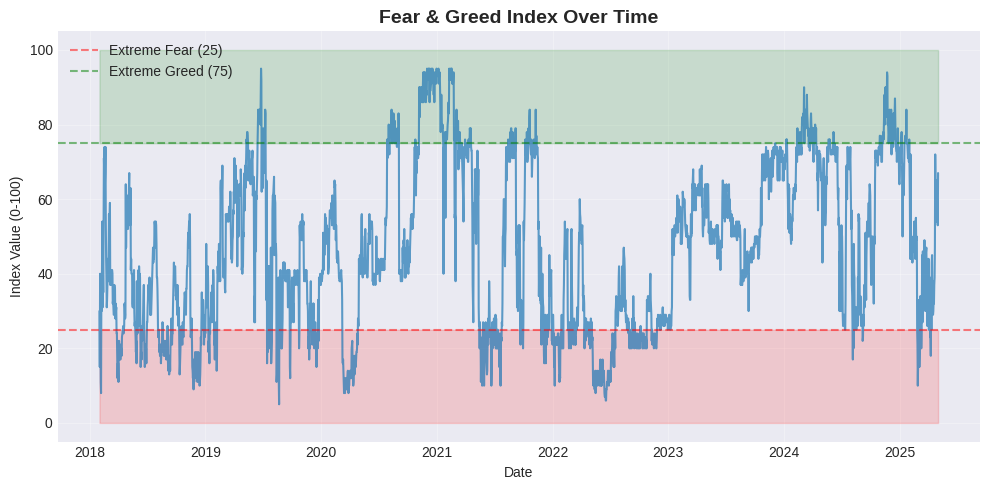

In [84]:
# 2. Fear & Greed Time Series
plt.figure(figsize=(10, 5))

plt.plot(fear_greed['date'], fear_greed['value'],
         linewidth=1.5, alpha=0.7, color='#1f77b4')

plt.axhline(y=25, color='red', linestyle='--', alpha=0.5, label='Extreme Fear (25)')
plt.axhline(y=75, color='green', linestyle='--', alpha=0.5, label='Extreme Greed (75)')

plt.fill_between(fear_greed['date'], 0, 25, alpha=0.15, color='red')
plt.fill_between(fear_greed['date'], 75, 100, alpha=0.15, color='green')

plt.title('Fear & Greed Index Over Time', fontsize=14, fontweight='bold')
plt.ylabel('Index Value (0-100)')
plt.xlabel('Date')
plt.legend(loc = 'upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


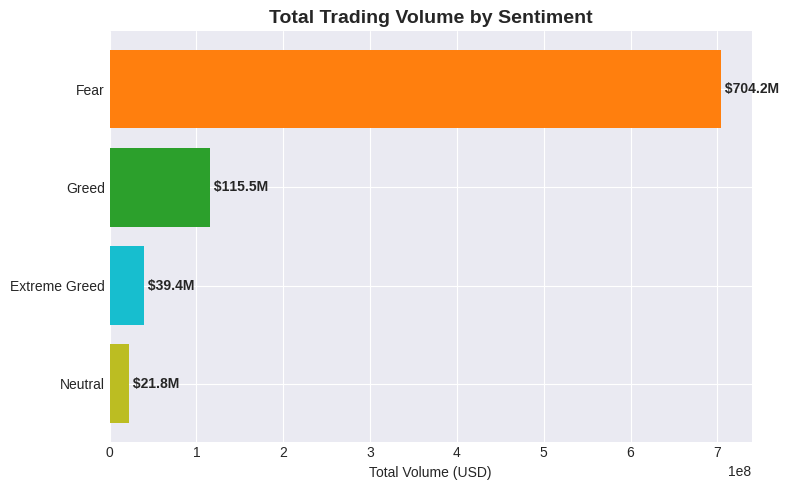

In [50]:
# 3. Trading Volume by Sentiment
plt.figure(figsize=(8, 5))

volume_by_sentiment = merged_data.groupby('classification')['total_volume'].sum().sort_values()

plt.barh(
    range(len(volume_by_sentiment)),
    volume_by_sentiment.values,
    color=[colors.get(x, '#888888') for x in volume_by_sentiment.index]
)

plt.yticks(range(len(volume_by_sentiment)), volume_by_sentiment.index)
plt.title('Total Trading Volume by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Total Volume (USD)')

for i, v in enumerate(volume_by_sentiment.values):
    label = f' ${v/1e6:.1f}M' if v >= 1e6 else f' ${v/1e3:.1f}K'
    plt.text(v, i, label, va='center', fontweight='bold')

plt.tight_layout()
plt.show()


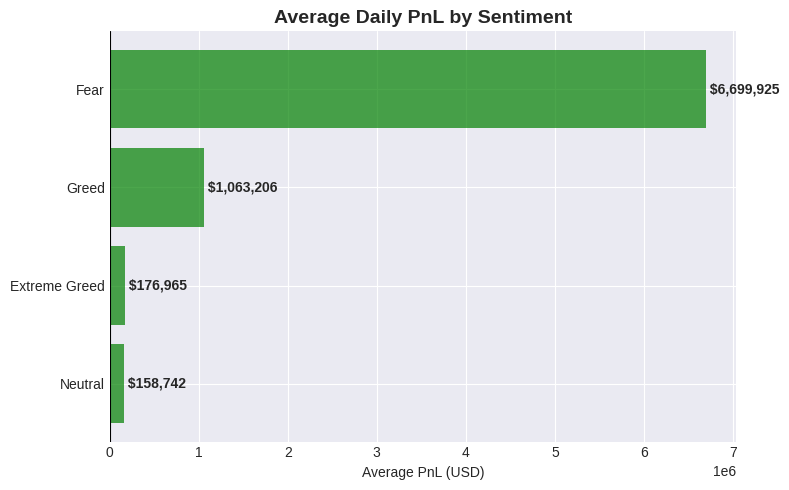

In [51]:
# 4. Average Daily PnL by Sentiment
plt.figure(figsize=(8, 5))

pnl_by_sentiment = merged_data.groupby('classification')['total_pnl'].mean().sort_values()
colors_pnl = ['red' if x < 0 else 'green' for x in pnl_by_sentiment.values]

plt.barh(
    range(len(pnl_by_sentiment)),
    pnl_by_sentiment.values,
    color=colors_pnl,
    alpha=0.7
)

plt.yticks(range(len(pnl_by_sentiment)), pnl_by_sentiment.index)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.title('Average Daily PnL by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Average PnL (USD)')

for i, v in enumerate(pnl_by_sentiment.values):
    plt.text(v, i, f' ${v:,.0f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


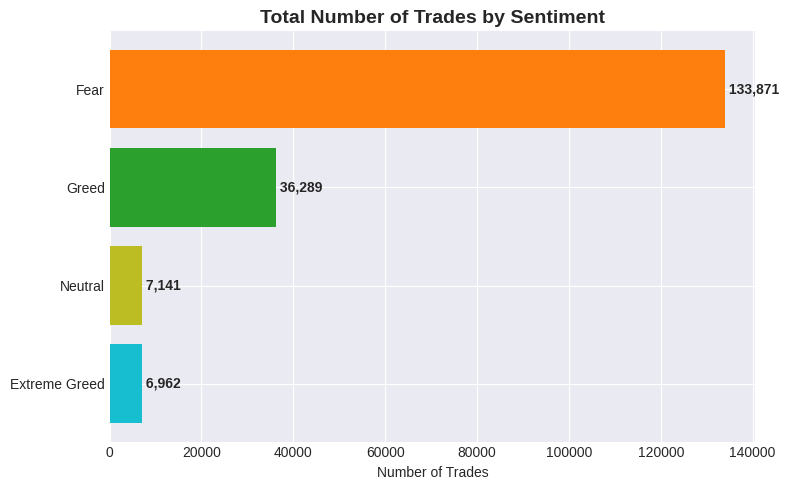

In [52]:
# 5. Number of Trades by Sentiment
plt.figure(figsize=(8, 5))

trades_by_sentiment = merged_data.groupby('classification')['num_trades'].sum().sort_values()

plt.barh(
    range(len(trades_by_sentiment)),
    trades_by_sentiment.values,
    color=[colors.get(x, '#888888') for x in trades_by_sentiment.index]
)

plt.yticks(range(len(trades_by_sentiment)), trades_by_sentiment.index)
plt.title('Total Number of Trades by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Number of Trades')

for i, v in enumerate(trades_by_sentiment.values):
    plt.text(v, i, f' {v:,}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


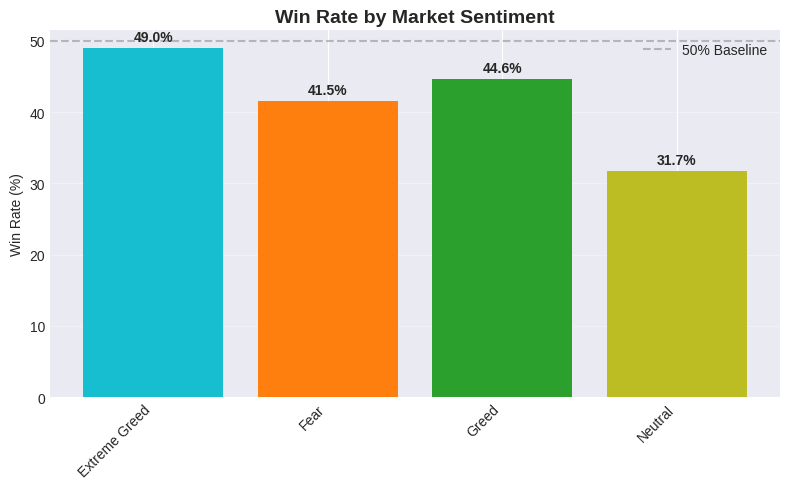

In [53]:
# 6. Win Rate by Sentiment
plt.figure(figsize=(8, 5))

win_rate_values = win_rates['win_rate_pct'].values
sentiment_labels = win_rates.index.tolist()

plt.bar(
    range(len(win_rates)),
    win_rate_values,
    color=[colors.get(x, '#888888') for x in sentiment_labels]
)

plt.xticks(range(len(win_rates)), sentiment_labels, rotation=45, ha='right')
plt.title('Win Rate by Market Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Win Rate (%)')

plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% Baseline')

for i, v in enumerate(win_rate_values):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


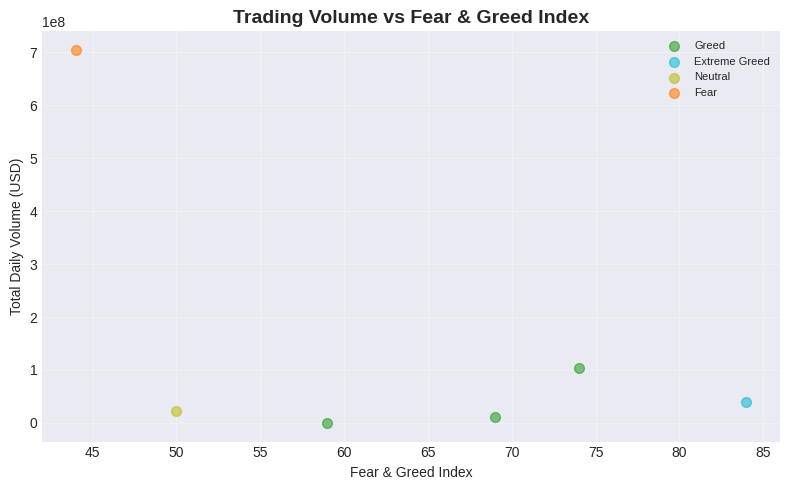

In [54]:
# 7. Volume vs Sentiment Scatter
plt.figure(figsize=(8, 5))

for sentiment in merged_data['classification'].unique():
    data = merged_data[merged_data['classification'] == sentiment]
    plt.scatter(
        data['value'],
        data['total_volume'],
        label=sentiment,
        alpha=0.6,
        s=50,
        color=colors.get(sentiment, '#888888')
    )

plt.title('Trading Volume vs Fear & Greed Index', fontsize=14, fontweight='bold')
plt.xlabel('Fear & Greed Index')
plt.ylabel('Total Daily Volume (USD)')
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


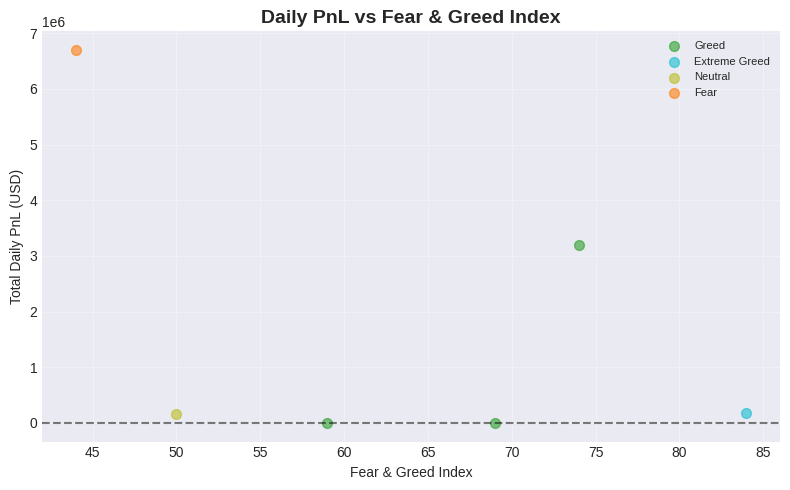

In [55]:
# 8. PnL vs Sentiment Scatter
plt.figure(figsize=(8, 5))

for sentiment in merged_data['classification'].unique():
    data = merged_data[merged_data['classification'] == sentiment]
    plt.scatter(
        data['value'],
        data['total_pnl'],
        label=sentiment,
        alpha=0.6,
        s=50,
        color=colors.get(sentiment, '#888888')
    )

plt.title('Daily PnL vs Fear & Greed Index', fontsize=14, fontweight='bold')
plt.xlabel('Fear & Greed Index')
plt.ylabel('Total Daily PnL (USD)')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


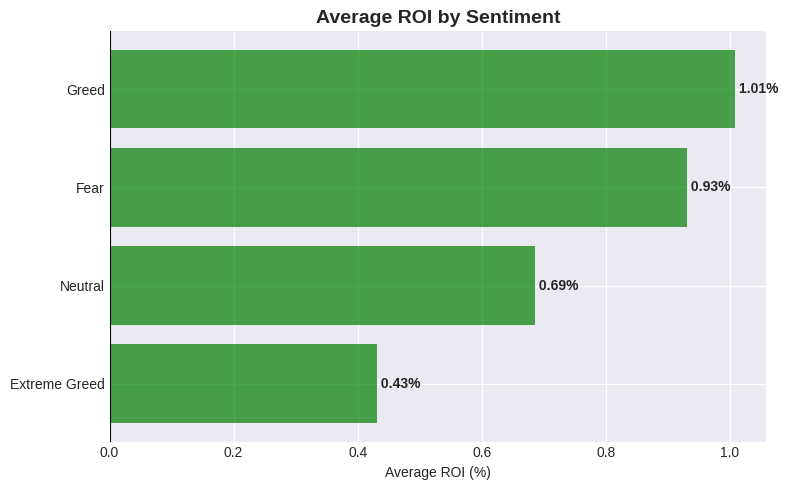

In [56]:
# 9. Average ROI by Sentiment
plt.figure(figsize=(8, 5))

roi_by_sentiment = merged_data.groupby('classification')['roi'].mean().sort_values()
colors_roi = ['red' if x < 0 else 'green' for x in roi_by_sentiment.values]

plt.barh(
    range(len(roi_by_sentiment)),
    roi_by_sentiment.values,
    color=colors_roi,
    alpha=0.7
)

plt.yticks(range(len(roi_by_sentiment)), roi_by_sentiment.index)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.title('Average ROI by Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Average ROI (%)')

for i, v in enumerate(roi_by_sentiment.values):
    plt.text(v, i, f' {v:.2f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


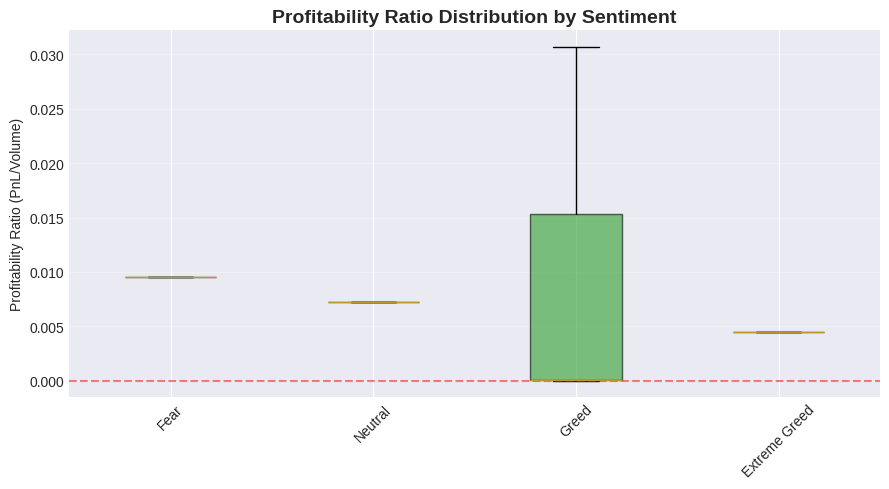

In [57]:
# 10. Profitability Ratio Distribution
plt.figure(figsize=(9, 5))

sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
existing_sentiments = [s for s in sentiment_order if s in merged_data['classification'].unique()]

data_for_box = [
    merged_data[merged_data['classification'] == s]['profitable_ratio'].values
    for s in existing_sentiments
]

bp = plt.boxplot(data_for_box, labels=existing_sentiments, patch_artist=True)

for patch, sentiment in zip(bp['boxes'], existing_sentiments):
    patch.set_facecolor(colors.get(sentiment, '#888888'))
    patch.set_alpha(0.6)

plt.title('Profitability Ratio Distribution by Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Profitability Ratio (PnL/Volume)')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


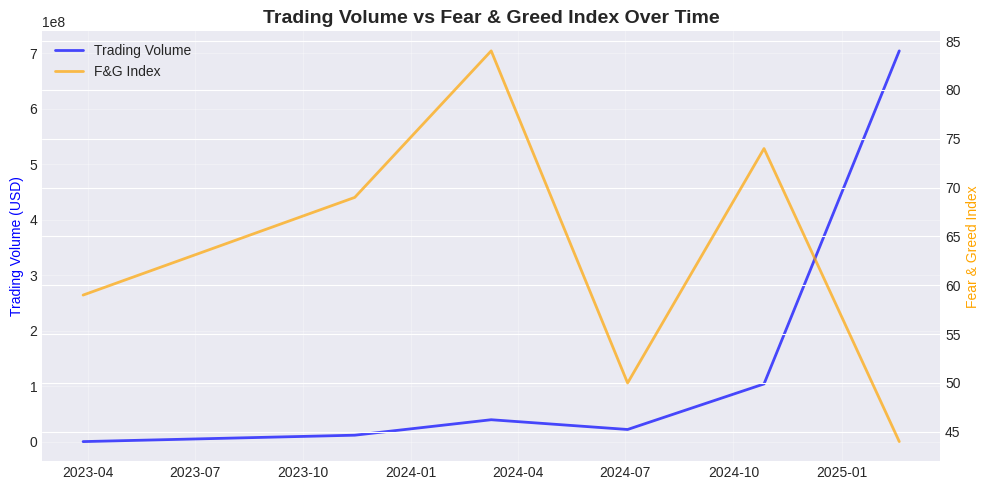

In [83]:
# 1. Volume Over Time
plt.figure(figsize=(10, 5))

ax1 = plt.gca()
ax1_twin = ax1.twinx()

ax1.plot(
    merged_data['date'],
    merged_data['total_volume'],
    color='blue',
    linewidth=2,
    alpha=0.7,
    label='Trading Volume'
)

ax1_twin.plot(
    merged_data['date'],
    merged_data['value'],
    color='orange',
    linewidth=2,
    alpha=0.7,
    label='F&G Index'
)

ax1.set_ylabel('Trading Volume (USD)', color='blue')
ax1_twin.set_ylabel('Fear & Greed Index', color='orange')

ax1.set_title(
    'Trading Volume vs Fear & Greed Index Over Time',
    fontsize=14,
    fontweight='bold'
)

ax1.grid(True, alpha=0.3)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()

ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='upper left'
)

plt.tight_layout()
plt.show()


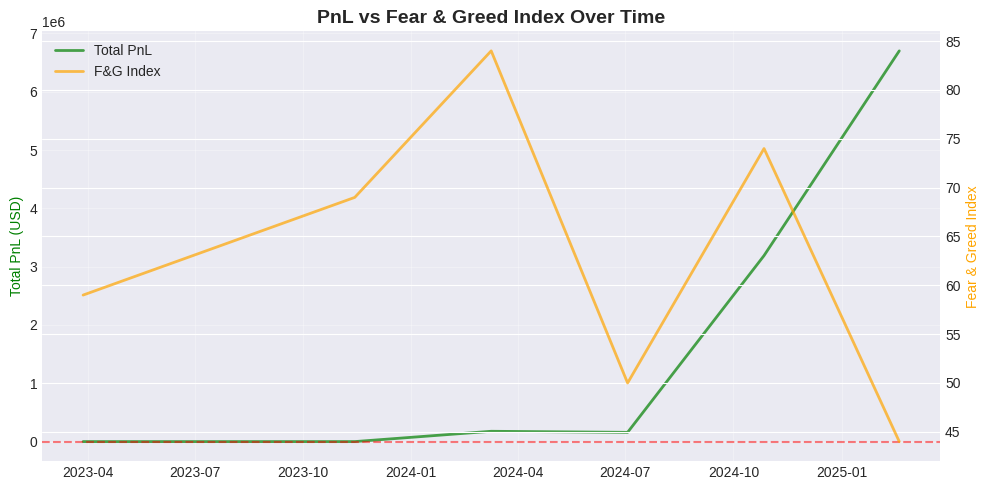

In [82]:
# 2. PnL Over Time
plt.figure(figsize=(10, 5))

ax2 = plt.gca()
ax2_twin = ax2.twinx()

ax2.plot(
    merged_data['date'],
    merged_data['total_pnl'],
    color='green',
    linewidth=2,
    alpha=0.7,
    label='Total PnL'
)

ax2_twin.plot(
    merged_data['date'],
    merged_data['value'],
    color='orange',
    linewidth=2,
    alpha=0.7,
    label='F&G Index'
)

ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

ax2.set_ylabel('Total PnL (USD)', color='green')
ax2_twin.set_ylabel('Fear & Greed Index', color='orange')

ax2.set_title(
    'PnL vs Fear & Greed Index Over Time',
    fontsize=14,
    fontweight='bold'
)

ax2.grid(True, alpha=0.3)
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()

ax2.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='upper left'
)

plt.tight_layout()
plt.show()


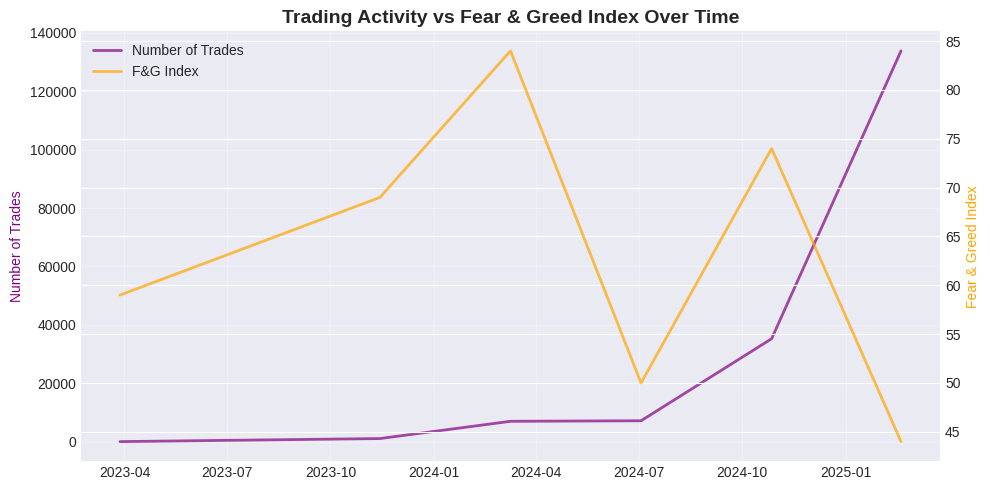

In [81]:
# 3. Trade Count Over Time
plt.figure(figsize=(10, 5))

ax3 = plt.gca()
ax3_twin = ax3.twinx()

ax3.plot(
    merged_data['date'],
    merged_data['num_trades'],
    color='purple',
    linewidth=2,
    alpha=0.7,
    label='Number of Trades'
)

ax3_twin.plot(
    merged_data['date'],
    merged_data['value'],
    color='orange',
    linewidth=2,
    alpha=0.7,
    label='F&G Index'
)

ax3.set_ylabel('Number of Trades', color='purple')
ax3_twin.set_ylabel('Fear & Greed Index', color='orange')

ax3.set_title(
    'Trading Activity vs Fear & Greed Index Over Time',
    fontsize=14,
    fontweight='bold'
)

ax3.grid(True, alpha=0.3)
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3_twin.get_legend_handles_labels()

ax3.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='upper left'
)

plt.tight_layout()
plt.show()


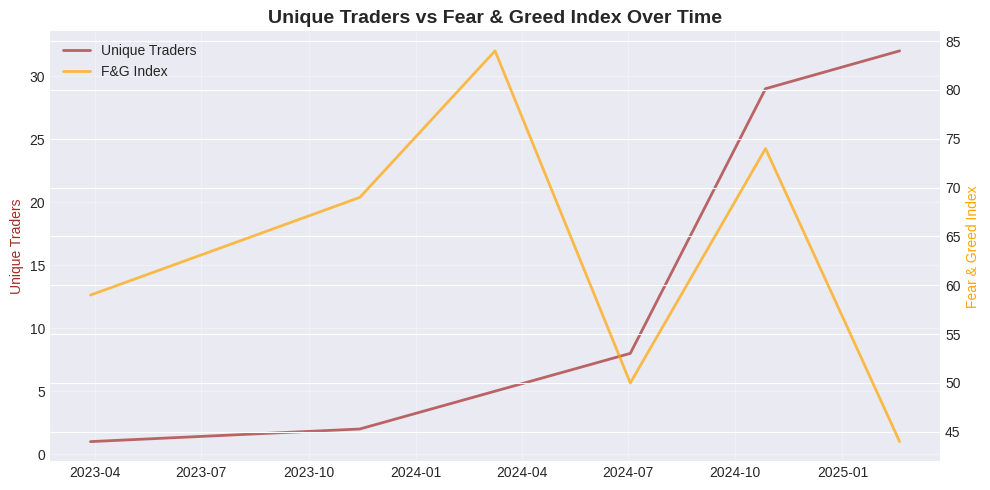

In [80]:
# 4. Unique Traders Over Time
plt.figure(figsize=(10, 5))

ax4 = plt.gca()
ax4_twin = ax4.twinx()

ax4.plot(
    merged_data['date'],
    merged_data['unique_traders'],
    color='brown',
    linewidth=2,
    alpha=0.7,
    label='Unique Traders'
)

ax4_twin.plot(
    merged_data['date'],
    merged_data['value'],
    color='orange',
    linewidth=2,
    alpha=0.7,
    label='F&G Index'
)

ax4.set_ylabel('Unique Traders', color='brown')
ax4_twin.set_ylabel('Fear & Greed Index', color='orange')

ax4.set_title(
    'Unique Traders vs Fear & Greed Index Over Time',
    fontsize=14,
    fontweight='bold'
)

ax4.grid(True, alpha=0.3)
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()

ax4.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='upper left'
)

plt.tight_layout()
plt.show()


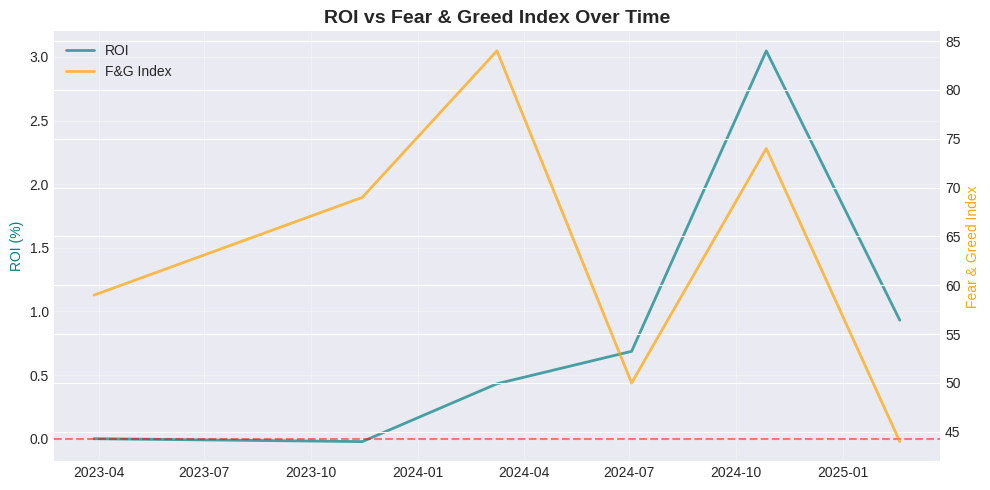

In [79]:
# 5. ROI Over Time
plt.figure(figsize=(10, 5))

ax5 = plt.gca()
ax5_twin = ax5.twinx()

ax5.plot(
    merged_data['date'],
    merged_data['roi'],
    color='teal',
    linewidth=2,
    alpha=0.7,
    label='ROI'
)

ax5_twin.plot(
    merged_data['date'],
    merged_data['value'],
    color='orange',
    linewidth=2,
    alpha=0.7,
    label='F&G Index'
)

ax5.axhline(y=0, color='red', linestyle='--', alpha=0.5)

ax5.set_ylabel('ROI (%)', color='teal')
ax5_twin.set_ylabel('Fear & Greed Index', color='orange')

ax5.set_title(
    'ROI vs Fear & Greed Index Over Time',
    fontsize=14,
    fontweight='bold'
)

ax5.grid(True, alpha=0.3)
lines1, labels1 = ax5.get_legend_handles_labels()
lines2, labels2 = ax5_twin.get_legend_handles_labels()

ax5.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='upper left'
)

plt.tight_layout()
plt.show()


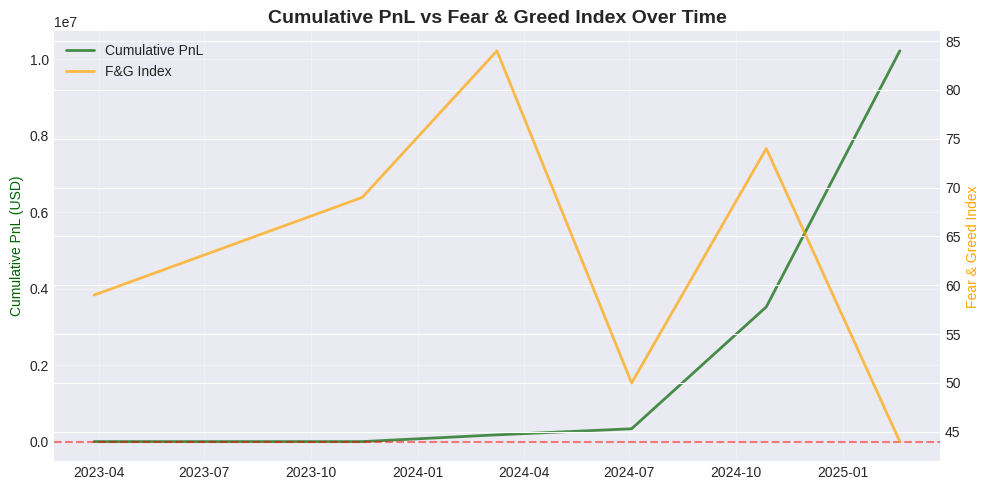

In [78]:
# 6. Cumulative PnL Over Time
plt.figure(figsize=(10, 5))

ax6 = plt.gca()
ax6_twin = ax6.twinx()

cumulative_pnl = merged_data['total_pnl'].cumsum()

ax6.plot(
    merged_data['date'],
    cumulative_pnl,
    color='darkgreen',
    linewidth=2,
    alpha=0.7,
    label='Cumulative PnL'
)

ax6_twin.plot(
    merged_data['date'],
    merged_data['value'],
    color='orange',
    linewidth=2,
    alpha=0.7,
    label='F&G Index'
)

ax6.axhline(y=0, color='red', linestyle='--', alpha=0.5)

ax6.set_ylabel('Cumulative PnL (USD)', color='darkgreen')
ax6_twin.set_ylabel('Fear & Greed Index', color='orange')

ax6.set_title(
    'Cumulative PnL vs Fear & Greed Index Over Time',
    fontsize=14,
    fontweight='bold'
)

ax6.grid(True, alpha=0.3)
lines1, labels1 = ax6.get_legend_handles_labels()
lines2, labels2 = ax6_twin.get_legend_handles_labels()

ax6.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc='upper left'
)

plt.tight_layout()
plt.show()


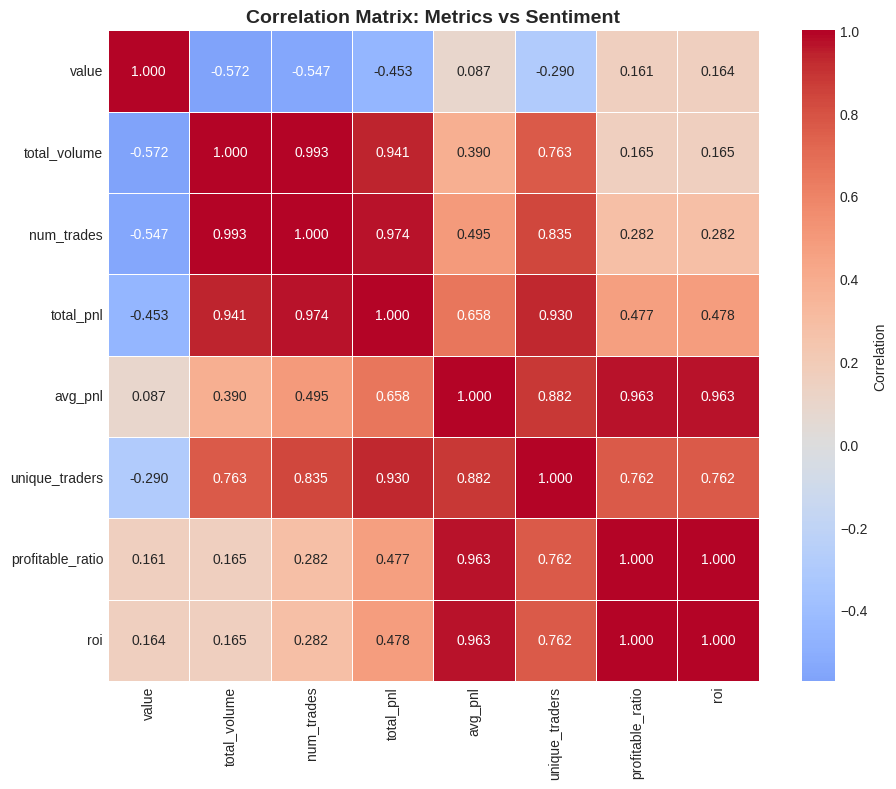

In [64]:
# 1. Correlation Heatmap
plt.figure(figsize=(10, 8))

corr_cols = [
    'value', 'total_volume', 'num_trades', 'total_pnl',
    'avg_pnl', 'unique_traders', 'profitable_ratio', 'roi'
]

correlation_matrix = merged_data[corr_cols].corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    cbar_kws={'label': 'Correlation'},
    linewidths=0.5
)

plt.title(
    'Correlation Matrix: Metrics vs Sentiment',
    fontsize=14,
    fontweight='bold'
)

plt.tight_layout()
plt.show()


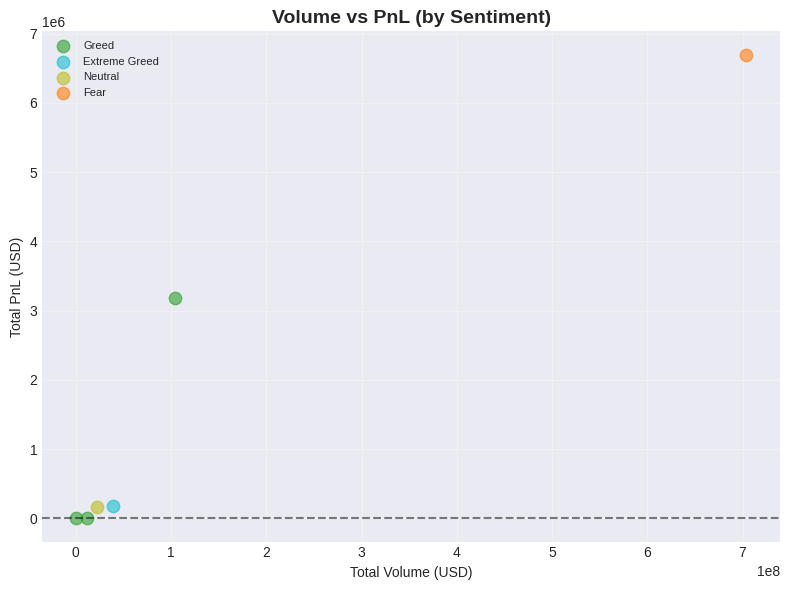

In [65]:
# 2. Volume vs PnL by Sentiment
plt.figure(figsize=(8, 6))

for sentiment in merged_data['classification'].unique():
    data = merged_data[merged_data['classification'] == sentiment]
    plt.scatter(
        data['total_volume'],
        data['total_pnl'],
        label=sentiment,
        alpha=0.6,
        s=80,
        color=colors.get(sentiment, '#888888')
    )

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.xlabel('Total Volume (USD)')
plt.ylabel('Total PnL (USD)')

plt.title(
    'Volume vs PnL (by Sentiment)',
    fontsize=14,
    fontweight='bold'
)

plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


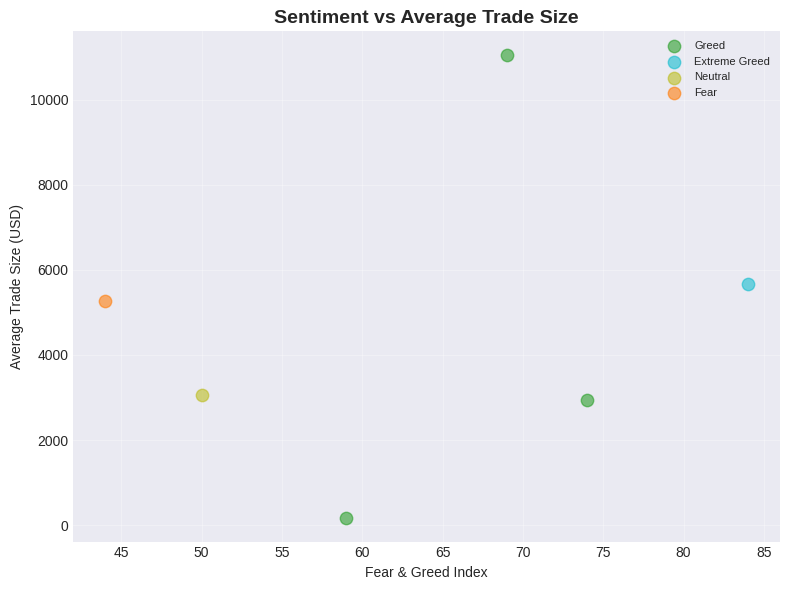

In [66]:
# 3. Sentiment vs Trade Size
plt.figure(figsize=(8, 6))

for sentiment in merged_data['classification'].unique():
    data = merged_data[merged_data['classification'] == sentiment]
    plt.scatter(
        data['value'],
        data['avg_trade_size'],
        label=sentiment,
        alpha=0.6,
        s=80,
        color=colors.get(sentiment, '#888888')
    )

plt.xlabel('Fear & Greed Index')
plt.ylabel('Average Trade Size (USD)')
plt.title('Sentiment vs Average Trade Size', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


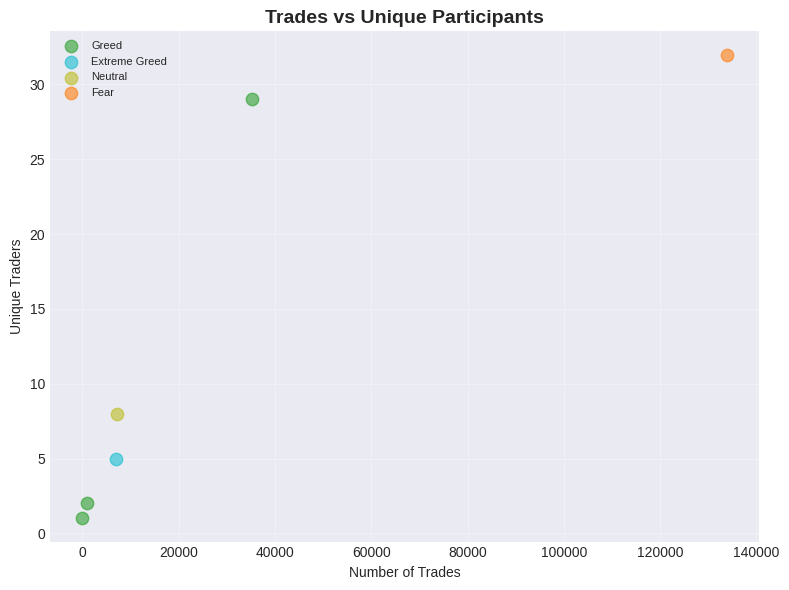

In [67]:
# 4. Trading Activity Patterns
plt.figure(figsize=(8, 6))

for sentiment in merged_data['classification'].unique():
    data = merged_data[merged_data['classification'] == sentiment]
    plt.scatter(
        data['num_trades'],
        data['unique_traders'],
        label=sentiment,
        alpha=0.6,
        s=80,
        color=colors.get(sentiment, '#888888')
    )

plt.xlabel('Number of Trades')
plt.ylabel('Unique Traders')
plt.title('Trades vs Unique Participants', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


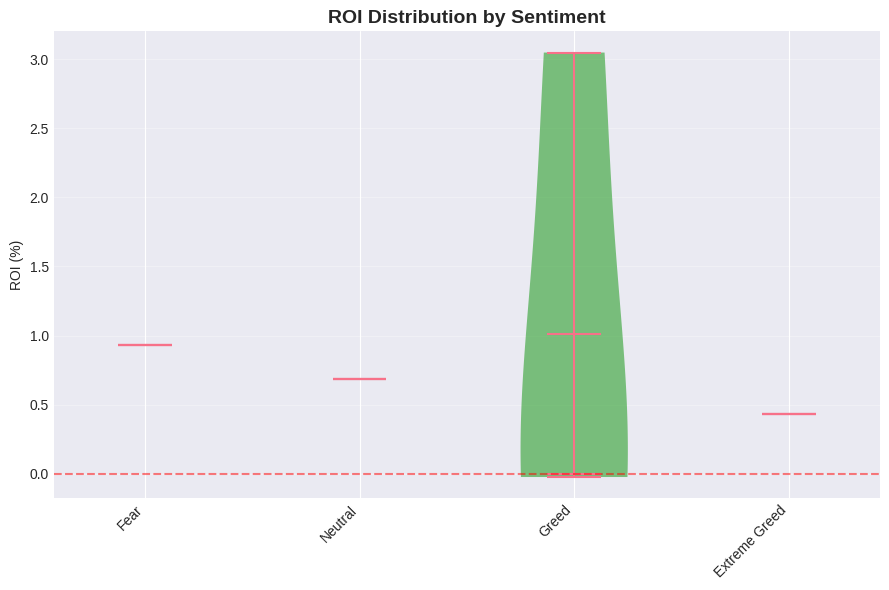

In [68]:
# 5. ROI Distribution by Sentiment
plt.figure(figsize=(9, 6))

existing_sentiments = [
    s for s in sentiment_order
    if s in merged_data['classification'].unique()
]

roi_data = [
    merged_data[merged_data['classification'] == s]['roi'].values
    for s in existing_sentiments
]

vp = plt.violinplot(
    roi_data,
    positions=range(len(roi_data)),
    showmeans=True,
    showmedians=True
)

for pc, sentiment in zip(vp['bodies'], existing_sentiments):
    pc.set_facecolor(colors.get(sentiment, '#888888'))
    pc.set_alpha(0.6)

plt.xticks(range(len(roi_data)), existing_sentiments, rotation=45, ha='right')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.ylabel('ROI (%)')
plt.title('ROI Distribution by Sentiment', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


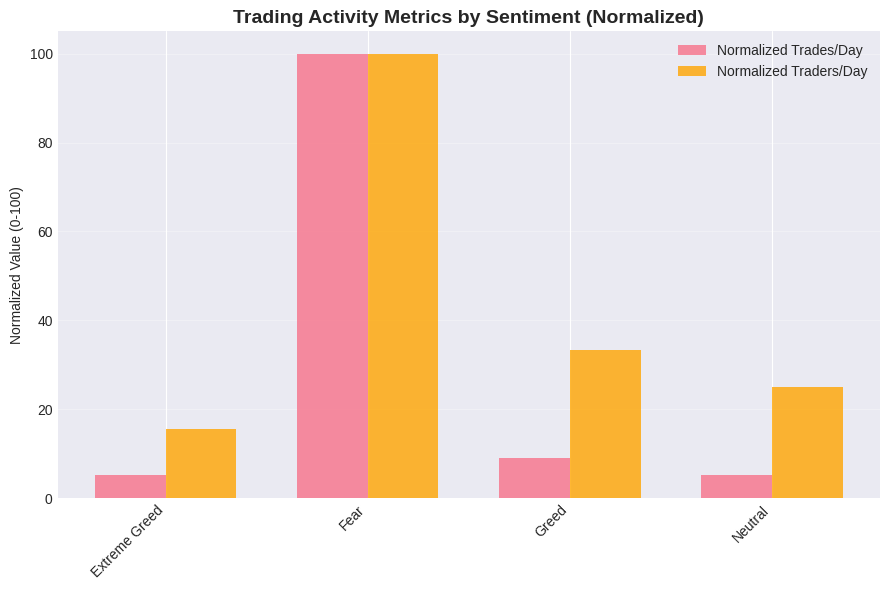

In [69]:
# 6. Average Metrics Comparison
plt.figure(figsize=(9, 6))

metrics_comparison = merged_data.groupby('classification')[['num_trades', 'unique_traders']].mean()

x = np.arange(len(metrics_comparison))
width = 0.35

# Normalize for comparison
norm_trades = metrics_comparison['num_trades'] / metrics_comparison['num_trades'].max() * 100
norm_traders = metrics_comparison['unique_traders'] / metrics_comparison['unique_traders'].max() * 100

plt.bar(
    x - width/2,
    norm_trades,
    width,
    label='Normalized Trades/Day',
    alpha=0.8

)

plt.bar(
    x + width/2,
    norm_traders,
    width,
    label='Normalized Traders/Day',
    alpha=0.8,
    color='orange'
)

plt.xticks(x, metrics_comparison.index, rotation=45, ha='right')
plt.ylabel('Normalized Value (0-100)')
plt.title('Trading Activity Metrics by Sentiment (Normalized)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


# KEY INSIGHTS CALCULATION

In [70]:

print("\n" + "=" * 80)
print("KEY INSIGHTS & FINDINGS")
print("=" * 80)

# Fear vs Greed comparison
fear_data = merged_data[merged_data['classification'].str.contains('Fear')]
greed_data = merged_data[merged_data['classification'].str.contains('Greed')]

print(f"\n🔍 TRADING VOLUME:")
print(f"  • Average volume during Fear periods: ${fear_data['total_volume'].mean():,.2f}")
print(f"  • Average volume during Greed periods: ${greed_data['total_volume'].mean():,.2f}")
if fear_data['total_volume'].mean() > 0:
    volume_diff = ((greed_data['total_volume'].mean() - fear_data['total_volume'].mean()) /
                   fear_data['total_volume'].mean() * 100)
    print(f"  • Difference: {volume_diff:+.1f}%")

print(f"\n💰 PROFITABILITY:")
print(f"  • Average PnL during Fear periods: ${fear_data['total_pnl'].mean():,.2f}")
print(f"  • Average PnL during Greed periods: ${greed_data['total_pnl'].mean():,.2f}")
pnl_diff = greed_data['total_pnl'].mean() - fear_data['total_pnl'].mean()
print(f"  • Difference: ${pnl_diff:+,.2f}")

print(f"\n🎯 WIN RATES:")
fear_win_rate = win_rates.loc[win_rates.index.str.contains('Fear'), 'win_rate_pct'].mean()
greed_win_rate = win_rates.loc[win_rates.index.str.contains('Greed'), 'win_rate_pct'].mean()
print(f"  • Win rate during Fear periods: {fear_win_rate:.2f}%")
print(f"  • Win rate during Greed periods: {greed_win_rate:.2f}%")
print(f"  • Difference: {(greed_win_rate - fear_win_rate):+.2f} percentage points")

print(f"\n📊 ROI:")
print(f"  • Average ROI during Fear: {fear_data['roi'].mean():.3f}%")
print(f"  • Average ROI during Greed: {greed_data['roi'].mean():.3f}%")
print(f"  • Difference: {(greed_data['roi'].mean() - fear_data['roi'].mean()):+.3f} pp")

# Correlations
corr_volume = merged_data['value'].corr(merged_data['total_volume'])
corr_pnl = merged_data['value'].corr(merged_data['total_pnl'])
corr_roi = merged_data['value'].corr(merged_data['roi'])
corr_winrate = merged_data['value'].corr(
    trader_with_sentiment.groupby('date')['is_profitable'].mean()
)

print(f"\n📈 CORRELATIONS WITH SENTIMENT INDEX:")
print(f"  • Sentiment ↔ Volume: {corr_volume:.3f}")
print(f"  • Sentiment ↔ PnL: {corr_pnl:.3f}")
print(f"  • Sentiment ↔ ROI: {corr_roi:.3f}")

print("\n💡 STRATEGIC INSIGHTS:")
if fear_data['roi'].mean() > greed_data['roi'].mean():
    print("  ✓ Contrarian signal detected: Better ROI during fear periods")
    print("  → Strategy: Consider buying during extreme fear, selling during greed")
else:
    print("  ✓ Momentum signal detected: Better ROI during greed periods")
    print("  → Strategy: Follow the trend during greedy markets")

if abs(corr_volume) > 0.3:
    direction = 'higher' if corr_volume > 0 else 'lower'
    print(f"  ✓ Strong correlation between sentiment and volume ({corr_volume:.3f})")
    print(f"  → Higher sentiment (greed) = {direction} trading activity")

if abs(corr_pnl) > 0.3:
    direction = 'higher' if corr_pnl > 0 else 'lower'
    print(f"  ✓ Strong correlation between sentiment and profitability ({corr_pnl:.3f})")
    print(f"  → Higher sentiment (greed) = {direction} profits")


KEY INSIGHTS & FINDINGS

🔍 TRADING VOLUME:
  • Average volume during Fear periods: $704,158,492.98
  • Average volume during Greed periods: $38,727,610.52
  • Difference: -94.5%

💰 PROFITABILITY:
  • Average PnL during Fear periods: $6,699,925.19
  • Average PnL during Greed periods: $841,645.51
  • Difference: $-5,858,279.68

🎯 WIN RATES:
  • Win rate during Fear periods: 41.51%
  • Win rate during Greed periods: 46.83%
  • Difference: +5.32 percentage points

📊 ROI:
  • Average ROI during Fear: 0.931%
  • Average ROI during Greed: 0.864%
  • Difference: -0.067 pp

📈 CORRELATIONS WITH SENTIMENT INDEX:
  • Sentiment ↔ Volume: -0.572
  • Sentiment ↔ PnL: -0.453
  • Sentiment ↔ ROI: 0.164

💡 STRATEGIC INSIGHTS:
  ✓ Contrarian signal detected: Better ROI during fear periods
  → Strategy: Consider buying during extreme fear, selling during greed
  ✓ Strong correlation between sentiment and volume (-0.572)
  → Higher sentiment (greed) = lower trading activity
  ✓ Strong correlation between

# SAVE SUMMARY REPORT

In [85]:
print("\n📝 Generating summary report...")

summary_data = {
    'Metric': [
        'Total Days Analyzed',
        'Total Trades',
        'Total Volume (USD)',
        'Total PnL (USD)',
        'Total Fees (USD)',
        'Net Profit (USD)',
        '',
        'Avg Volume - Fear',
        'Avg Volume - Greed',
        'Volume Difference %',
        '',
        'Avg PnL - Fear',
        'Avg PnL - Greed',
        'PnL Difference',
        '',
        'Win Rate - Fear',
        'Win Rate - Greed',
        'Win Rate Diff',
        '',
        'ROI - Fear',
        'ROI - Greed',
        'ROI Difference',
        '',
        'Correlation: Sentiment-Volume',
        'Correlation: Sentiment-PnL',
        'Correlation: Sentiment-ROI'
    ],
    'Value': [
        str(len(merged_data)),
        f"{trader_data.shape[0]:,}",
        f"${trader_data['Size USD'].sum():,.2f}",
        f"${trader_data['Closed PnL'].sum():,.2f}",
        f"${trader_data['Fee'].sum():,.2f}",
        f"${trader_data['Closed PnL'].sum() - trader_data['Fee'].sum():,.2f}",
        '',
        f"${fear_data['total_volume'].mean():,.2f}",
        f"${greed_data['total_volume'].mean():,.2f}",
        f"{volume_diff:+.1f}%" if fear_data['total_volume'].mean() > 0 else 'N/A',
        '',
        f"${fear_data['total_pnl'].mean():,.2f}",
        f"${greed_data['total_pnl'].mean():,.2f}",
        f"${pnl_diff:+,.2f}",
        '',
        f"{fear_win_rate:.2f}%",
        f"{greed_win_rate:.2f}%",
        f"{(greed_win_rate - fear_win_rate):+.2f} pp",
        '',
        f"{fear_data['roi'].mean():.3f}%",
        f"{greed_data['roi'].mean():.3f}%",
        f"{(greed_data['roi'].mean() - fear_data['roi'].mean()):+.3f} pp",
        '',
        f"{corr_volume:.3f}",
        f"{corr_pnl:.3f}",
        f"{corr_roi:.3f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('analysis_summary.csv', index=False)
print("✓ Saved: analysis_summary.csv")

# Save detailed statistics
sentiment_stats.to_csv('detailed_sentiment_statistics.csv')
print("✓ Saved: detailed_sentiment_statistics.csv")

win_rates.to_csv('win_rate_analysis.csv')
print("✓ Saved: win_rate_analysis.csv")

# ============================================================================
# COMPLETION
# ============================================================================
print("\n" + "=" * 80)
print("ANALYSIS COMPLETE!")
print("=" * 80)
print("\n✅ Generated Files:")
print("   1. sentiment_analysis_dashboard.png - Main 10-panel visualization")
print("   2. temporal_analysis.png - Time series analysis (6 panels)")
print("   3. correlation_analysis.png - Advanced correlations (6 panels)")
print("   4. analysis_summary.csv - Key metrics summary")
print("   5. detailed_sentiment_statistics.csv - Full statistics by sentiment")
print("   6. win_rate_analysis.csv - Win rate breakdown")
print("\n📊 All visualizations saved at 300 DPI for publication quality")
print("=" * 80)


📝 Generating summary report...
✓ Saved: analysis_summary.csv
✓ Saved: detailed_sentiment_statistics.csv
✓ Saved: win_rate_analysis.csv

ANALYSIS COMPLETE!

✅ Generated Files:
   1. sentiment_analysis_dashboard.png - Main 10-panel visualization
   2. temporal_analysis.png - Time series analysis (6 panels)
   3. correlation_analysis.png - Advanced correlations (6 panels)
   4. analysis_summary.csv - Key metrics summary
   5. detailed_sentiment_statistics.csv - Full statistics by sentiment
   6. win_rate_analysis.csv - Win rate breakdown

📊 All visualizations saved at 300 DPI for publication quality
